# This notebook we will compare the eCLIP density on genes that are upregulated and downregulated upon RBP KD
This allows us to generate hypothesis about RBP function - whether it stabilize or destabilize RNA?

In [1]:
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt

# load IDs
encode_data = pd.read_pickle('~/projects/eclip_encode_id.pickle')
eclip_bam = pd.read_csv('/home/hsher/projects/RBP_annot/ENCODE_FINAL_ANNOTATIONS.uidsonly.txt.manifesthg38.txt', sep = '\t', header= 0)

# join data
encode_data = pd.merge(eclip_bam[['uID', 'RBP', 'Cell line']], encode_data, left_on = ['RBP', 'Cell line'], right_on = ['RBP', 'cell_line'])

# Get all the DESeq files for each KD experiment

In [2]:
# parse DE filenames
de_path = '/home/hsher/deseq_gccor/normalized/'
all_de_files = os.listdir(de_path)
all_de_files.remove('result_URLs_HepG2.txt')
all_de_files.remove('result_URLs_K562.txt')
all_de_files_rbp = [f.split('-')[0] for f in all_de_files if '-' in f]
all_de_files_cell = [f.split('-')[2].split('_')[0] for f in all_de_files if '-' in f]
de_df = pd.DataFrame([all_de_files, all_de_files_rbp, all_de_files_cell]).T
de_df.columns = ['fname', 'rbp', 'cell line']

In [3]:
de_df.head()

,fname,rbp,cell line
0,PRPF8-BGHLV17-HepG2_DESeq2_output.txt,PRPF8,HepG2
1,RECQL-LV08-K562_DESeq2_output.txt,RECQL,K562
2,TRIM56-BGHLV20-HepG2_DESeq2_output.txt,TRIM56,HepG2
3,ESF1-BGHLV30-HepG2_DESeq2_output.txt,ESF1,HepG2
4,MTPAP-BGKLV34-K562_DESeq2_output.txt,MTPAP,K562


# These are the RBPs with more DE events!

In [46]:
def DEseq_result(fname):
    ''' return transcript ID that is up and down regulated'''
    # read DEseq results
    de = pd.read_csv(de_path+ fname, sep = '\t', header = 0, index_col = 0)
    
    # select those significant
    de = de[de['padj']< 0.05]
    de.reset_index(inplace = True)
    
    # select fold change high
    up = de.loc[de['log2FoldChange']> 1]
    down = de.loc[de['log2FoldChange']< -1]
    
    # remove version
    up = [i.split('.')[0] for i in up['index'].tolist()]
    down = [i.split('.')[0] for i in down['index'].tolist()]
    return up, down
    
def find_direct_bind(id_list, eCLIP):
    ''' find DE genes that has at least 1 idr peak'''
    subset = transcript.filter(lambda x: x.attrs['gene_id'].split('.')[0] in id_list).saveas()
    direct_bind_transcript = subset.intersect(eCLIP.idr, s = True, u = True).saveas()
    
    return direct_bind_transcript

def main(cell_line, rbp):
    # start eCLIP object for you
    e = eCLIP()
    e.build_ENCODE(encode_data.loc[(encode_data['RBP'] == rbp)&(encode_data['Cell line'] == cell_line)])
    
    # fetch DE genes
    fname = de_df.loc[(de_df['rbp'] == rbp) & (de_df['cell line'] == cell_line), 'fname'].values[0]
    up, down = DEseq_result(fname)
    up_transcripts = find_direct_bind(up, LIN28B)
    down_transcripts = find_direct_bind(down, LIN28B)

    print('# up reg: {} # down reg: {}'.format(len(up_transcripts), len(down_transcripts)))
    
    # then we create metadensity for each of them
    meta_up = Metadensity(e, up_transcripts, rbp+'_upreg')
    meta_down = Metadensity(e, down_transcripts, rbp+'_downreg')

    # run
    
    for m in [meta_up, meta_down]:
        m.get_density_array()
        
    return [meta_up, meta_down]

## Compare upregulated genes (logFC > 1) and downregulated genes (logFC <1)'s binding

In [47]:
ddx_metas = main('HepG2', 'DDX3X')

67 210
Done Building Metagene
Done Building Metagene


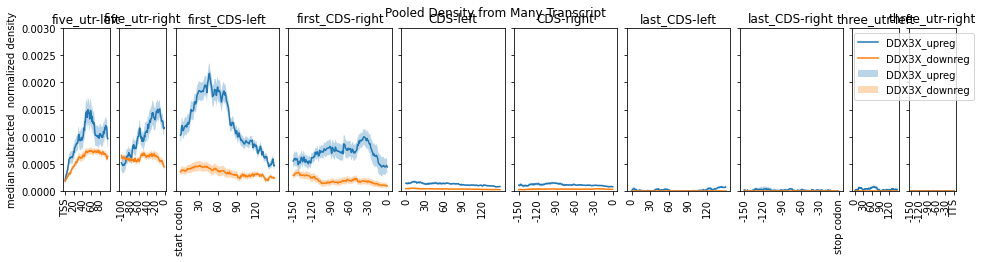

In [50]:
protein_coding = ['five_utr', 'first_CDS', 'CDS', 'last_CDS', 'three_utr']
f = plot_mean_density(ddx_metas, plot_std = True, stat = 'median', ymax = 0.003, alpha = 0.3, features_to_show = protein_coding)

### DDX3X bound transcript tend to be upregulated upon DDX KD
--> hypothesis: DDX3X kills RNA, so when DDX3X is gone, RNA survive and has a higher steady state concentration.

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/plotd.py:152: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


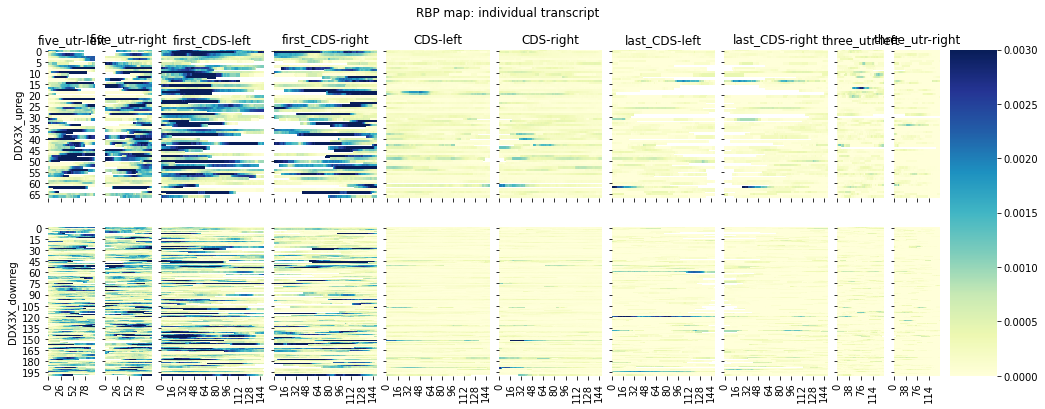

In [51]:
# individually
f = plot_rbp_map(ddx_metas, ymax = 0.003, alpha = 0.3, features_to_show = protein_coding)